# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [37]:
import tensorflow as tf
import numpy as np
import os

### 1. Data loading & preprocessing

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [3]:
import zipfile

# Prepare the training and testing image sets.
def unzipDataset(data_dir):
    zip_path = data_dir + '.zip'
    extract_path = os.getcwd()

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

train_dir = 'train'
test_dir = 'test'

unzipDataset(train_dir)
unzipDataset(test_dir)

### prepare training and test dataset for yolo

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import psutil

# Function to close all open files
def close_all_open_files():
    # Get the current process
    process = psutil.Process(os.getpid())
    
    # List all open file descriptors
    for fd in process.open_files():
        try:
            os.close(fd.fd)
        except OSError:
            # The file descriptor might already be closed
            pass

# Close all open file descriptors
close_all_open_files()

path = os.getcwd() 

# Construct the train path
train_path = os.path.join(path, 'train')
train_csv_path = os.path.join(path,'train.csv')
df_train_csv = pd.read_csv(train_csv_path)

imgs = os.scandir(train_path)
train_data = []

print(imgs)
for img in imgs :
    if img.is_dir() or img.is_file():
        img_id = img.name.split('_')[1].replace('.png','')
        img_id = int(img_id)
        if img_id in df_train_csv['id'].values:
            corresponding_row = df_train_csv[df_train_csv['id'] == img_id]
            image_name = img.name
            image = Image.open(img.path)
            # Append the image, filename, and DataFrame row to train_data
            train_data.append({
                'image': image,
                'name' : image_name,
                'lable': corresponding_row['label'].values[0]
            })

df = pd.DataFrame(train_data)     


The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [77]:
from PIL import Image, ImageEnhance
img = Image.open(os.path.join(train_path,'image_600.png'))

df['lable'].value_counts()
df_group = df.groupby('lable')

In [9]:
# Define a function to save images
def save_images(df, base_output_dir):
    for index, row in df.iterrows():
        image_path = os.path.join(train_path, row['name'])
        label = row['lable']
        label_dir = os.path.join(base_output_dir, str(label))
        # Load the image
        image = Image.open(image_path)
        # Define the output path
        output_path = os.path.join(label_dir,row['name'])
        # Save the image
        image.save(output_path)

def classify_folders(data):
    new_path = os.path.join(path, data)
    if data == "train_data":
        if not os.path.exists(new_path):
            os.mkdir(new_path)
            labels = df['lable'].unique()
            # Create a directory for each label
            for label in labels:
                label_dir = os.path.join(new_path, str(label))
                if not os.path.exists(label_dir):
                    os.makedirs(label_dir)
            save_images(df, new_path)

classify_folders("train_data")

### preprocess images
- Resize:
  Resizes the image to a consistent size, which is important for ensuring that images are the same dimensions before further processing or model input.

- Brightness Adjustment:
  Brightness enhancement is useful for making images more visible and distinct. It scales pixel values to increase overall brightness.

- Saturation Adjustment:
  Increases the color intensity, making the colors more vivid. Saturation adjustment can help in enhancing or correcting color imbalances.
  Contrast Adjustment:
  Adjusts the difference between light and dark areas of the image. The contrast_factor can be modified to enhance or reduce contrast.

- CLAHE:
  CLAHE is used to improve the contrast of the image by equalizing the histogram of the value (brightness) channel. This method can enhance details in different regions of the image.

In [4]:
import cv2


def process_imgs(img):
  # 1. Resize the Image
  # img = cv2.imread(os.path.join(train_path,img_name))
  resize_dim = (250, 250)  # Width, Height
  img_resized = cv2.resize(img, resize_dim)

  # 2. Adjust Brightness
  # Increase brightness by multiplying pixel values (simple linear transformation)
  brightness_factor = 1.1
  img_bright = cv2.convertScaleAbs(img_resized, alpha=brightness_factor, beta=0)

  # 3. Adjust Saturation
  # Convert to HSV color space
  img_hsv = cv2.cvtColor(img_bright, cv2.COLOR_BGR2HSV)

  # Increase saturation (value range is 0-255)
  saturation_factor = 2.5
  max_saturation = 255  # Maximum saturation value
  # Increase saturation with a limit
  img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] * saturation_factor, 0, max_saturation)

  # Optional: Apply a custom maximum limit for saturation
  saturation_limit = 200
  img_hsv[:, :, 1] = np.minimum(img_hsv[:, :, 1], saturation_limit)

  # Convert back to BGR color space
  img_saturated = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

  # 4. Adjust Contrast
  # Increase contrast by multiplying pixel values
  contrast_factor = 1.0
  img_contrast = cv2.convertScaleAbs(img_saturated, alpha=contrast_factor, beta=0)

  # 5. Apply CLAHE to the Value Channel in HSV Color Space
  img_hsv = cv2.cvtColor(img_contrast, cv2.COLOR_BGR2HSV)
  clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
  img_hsv[:, :, 2] = clahe.apply(img_hsv[:, :, 2])  # Apply CLAHE to the V channel
  img_clahe_bgr = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

  return img_clahe_bgr


## preprocess data for MLP and CNN

### for MLP and CNN data prepare

In [38]:
from keras.utils import to_categorical

def load_train_data(root_dir, csv_file):
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        # image = process_imgs(image)
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    return np.array(ids), np.array(images), np.array(labels)

def load_test_data(root_dir):
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    return np.array(ids), np.array(images)

# Load training, testing data, and the training label provided in train.csv.
train_csv = 'train.csv'
train_dir = 'train'
test_dir = 'test'
id_train, X_train, y_train = load_train_data(train_dir, train_csv)
id_test, X_test = load_test_data(test_dir)

# Normalize the data.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors.
y_train = to_categorical(y_train, 10)


In [39]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
X_test shape: (5000, 32, 32, 3)


### 2. Build & train the model

This code demostrates a simple Multi-Layer Perceptron (MLP) model. However, you are encouraged to experiment with more complex deep learning models and techniques to boost your performance.

- I dont understand why we need to split the dataset if there is validation split function in the model....but anyway I will do it fot the perpose of showing matrix of the evaluation such as ROC curve and confusion matrices.

- split train validation data

In [42]:
from sklearn.model_selection import train_test_split
# Split data
X_new_train, X_val, y_new_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=101)

## MLP

Epoch 1/50


/Users/vitaliigalkin/Desktop/MSA-Phase2/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1676 - loss: 2.2061 - val_accuracy: 0.2449 - val_loss: 1.9885
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2471 - loss: 1.9863 - val_accuracy: 0.2786 - val_loss: 1.9447
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2694 - loss: 1.9506 - val_accuracy: 0.2804 - val_loss: 1.9495
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2814 - loss: 1.9363 - val_accuracy: 0.2893 - val_loss: 1.9213
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2921 - loss: 1.9157 - val_accuracy: 0.2793 - val_loss: 1.9520
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2916 - loss: 1.9034 - val_accuracy: 0.2982 - val_loss: 1.9438
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2992 - loss: 1.8964 - val_accuracy: 0.3038 - val_loss: 1.8893
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2990 - loss: 1.8929 - val_accurac

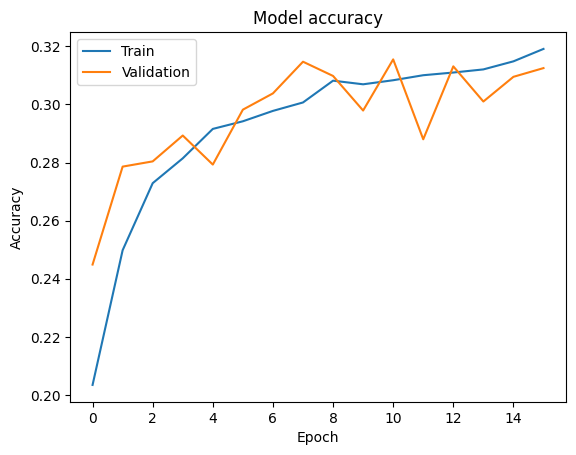

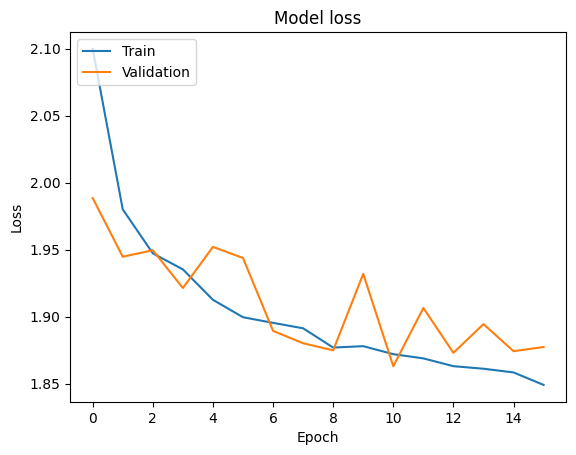

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step


In [8]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

X_train = X_train.reshape(-1, 3072)
X_test = X_test.reshape(-1, 3072)
# Model initialization.
model = tf.keras.Sequential()
 
# Build the MLP model.
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10,  activation="softmax"))

# Complile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Plot the training and validation loss/accuracy if needed to visualize the tuning process
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare your submission file
submission = np.column_stack((id_test, predicted_labels))
np.savetxt('submission_MLP.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

The plots illustrate the relationship between epochs and model accuracy, showing that the model's performance is suboptimal with the highest accuracy reaching only around 0.32. The accuracy increases initially but shows a distinct "elbow" or point of diminishing returns around epoch 4, where the improvement rate slows significantly. This suggests that the model may have reached its capacity for learning with the current configuration, and further training yields minimal gains. To address this, consider exploring additional model architectures, tuning hyperparameters, or augmenting the data to improve performance.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
Accuracy: 0.33
Precision: 0.32
Recall: 0.33
F1-Score: 0.30


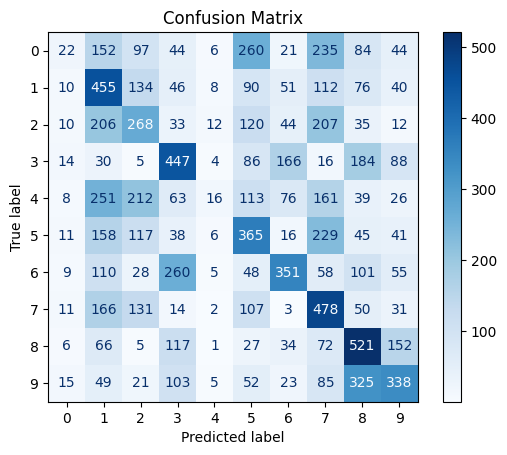

In [12]:
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                             f1_score, accuracy_score, ConfusionMatrixDisplay)

val_predictions = model.predict(X_val)
val_pred_labels = np.argmax(val_predictions, axis=1)
accuracy = accuracy_score(np.argmax(y_val, axis=1), val_pred_labels)
precision = precision_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
cm = confusion_matrix(np.argmax(y_val, axis=1), val_pred_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


- An accuracy of 0.33 (or 33%) indicates that the model correctly classified one-third of the instances. This is relatively low, especially if there are more classes. It suggests that the model's overall performance is not satisfactory and it might be struggling to differentiate between the classes effectively.
- The precision shows how good it is for the model to choose true positive cases that the acurracy of the model, and in this case the precision is 0.32, it is relatively low.
- The recall shows how sensity the model is to pick up the true positive cases from all actual positive instances, and here the recall is 0.33, which is also low. 
- F1- Score shows the balance of precision and recall.  An F1-score of 0.30 indicates that the model's ability to balance precision and recall is also low.

Overall, the model performace is low.

## CNN

In [14]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (50000, 3072)
y_train shape: (50000, 10)
X_test shape: (5000, 3072)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

INPUT_SHAPE = (32, 32, 3)
KERNEL_SIZE = (3, 3)
model_cnn = Sequential()

# Convolutional Layer
model_cnn.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=32, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
# Pooling layer
model_cnn.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=64, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=128, kernel_size=KERNEL_SIZE, input_shape=INPUT_SHAPE, activation='relu', padding='same'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPool2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
# model.add(Dropout(0.2))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

/Users/vitaliigalkin/Desktop/MSA-Phase2/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
batch_size = 32

# Assuming original dimensions were 32x32 with 3 color channels (RGB)
original_shape = (32, 32, 3)

# Reshape back to original dimensions
X_train = X_train.reshape(-1, *original_shape)
print(X_train.shape)
X_test = X_test.reshape(-1, *original_shape)


steps_per_epoch = X_train.shape[0] // batch_size



r = model_cnn.fit(X_train,
              y_train, 
              batch_size,
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_split = 0.2, 
              # callbacks=[early_stop],
              # batch_size=batch_size,
             )

(50000, 32, 32, 3)
Epoch 1/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.3082 - loss: 1.9539 - precision: 0.4998 - recall: 0.1007

2024-08-02 13:07:14.293501: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 78s 49ms/step - accuracy: 0.3250 - loss: 1.8982 - precision: 0.5245 - recall: 0.1163 - val_accuracy: 0.3136 - val_loss: 2.0885 - val_precision: 0.5106 - val_recall: 0.1862
Epoch 2/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.5283 - loss: 1.3078 - precision: 0.7129 - recall: 0.3536

2024-08-02 13:08:29.951146: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 75s 48ms/step - accuracy: 0.5331 - loss: 1.2973 - precision: 0.7157 - recall: 0.3598 - val_accuracy: 0.4248 - val_loss: 1.8222 - val_precision: 0.5681 - val_recall: 0.3062
Epoch 3/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.6295 - loss: 1.0523 - precision: 0.7706 - recall: 0.4930 - val_accuracy: 0.6566 - val_loss: 0.9750 - val_precision: 0.8077 - val_recall: 0.5203
Epoch 4/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.6821 - loss: 0.9149 - precision: 0.8023 - recall: 0.5668

2024-08-02 13:10:57.266168: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.6829 - loss: 0.9134 - precision: 0.8025 - recall: 0.5686 - val_accuracy: 0.6556 - val_loss: 1.0334 - val_precision: 0.7840 - val_recall: 0.5420
Epoch 5/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 73s 47ms/step - accuracy: 0.7227 - loss: 0.8100 - precision: 0.8217 - recall: 0.6272 - val_accuracy: 0.5279 - val_loss: 1.5651 - val_precision: 0.5983 - val_recall: 0.4676
Epoch 6/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.7493 - loss: 0.7404 - precision: 0.8339 - recall: 0.6633 - val_accuracy: 0.6921 - val_loss: 0.9057 - val_precision: 0.7774 - val_recall: 0.6157
Epoch 7/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 76s 48ms/step - accuracy: 0.7625 - loss: 0.6916 - precision: 0.8463 - recall: 0.6870 - val_accuracy: 0.7082 - val_loss: 0.8840 - val_precision: 0.7948 - val_recall: 0.6448
Epoch 8/50
1250/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7798 - loss: 0.6401 - precision: 0.8521 - recall: 0.7136

2024-08-02 13:15:58.450626: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.7796 - loss: 0.6401 - precision: 0.8522 - recall: 0.7136 - val_accuracy: 0.7435 - val_loss: 0.7879 - val_precision: 0.8264 - val_recall: 0.6760
Epoch 9/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 77s 50ms/step - accuracy: 0.7937 - loss: 0.5973 - precision: 0.8627 - recall: 0.7342 - val_accuracy: 0.7586 - val_loss: 0.7373 - val_precision: 0.8210 - val_recall: 0.7065
Epoch 10/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 77s 49ms/step - accuracy: 0.8119 - loss: 0.5487 - precision: 0.8701 - recall: 0.7561 - val_accuracy: 0.6228 - val_loss: 1.2557 - val_precision: 0.7183 - val_recall: 0.5652
Epoch 11/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.8187 - loss: 0.5261 - precision: 0.8760 - recall: 0.7678 - val_accuracy: 0.7474 - val_loss: 0.7688 - val_precision: 0.8189 - val_recall: 0.6907
Epoch 12/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 76s 49ms/step - accuracy: 0.8276 - loss: 0.4994 - precision: 0.8805 - recall: 0.7789 - val_accuracy: 0.7896 - 

2024-08-02 13:26:20.430942: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 78s 50ms/step - accuracy: 0.8644 - loss: 0.4043 - precision: 0.8999 - recall: 0.8277 - val_accuracy: 0.6360 - val_loss: 1.3738 - val_precision: 0.6911 - val_recall: 0.5919
Epoch 17/50
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 79s 50ms/step - accuracy: 0.8648 - loss: 0.3823 - precision: 0.9028 - recall: 0.8336 - val_accuracy: 0.7918 - val_loss: 0.6941 - val_precision: 0.8331 - val_recall: 0.7639
Epoch 18/50
 699/1562 ━━━━━━━━━━━━━━━━━━━━ 52s 61ms/step - accuracy: 0.8795 - loss: 0.3480 - precision: 0.9137 - recall: 0.8490

KeyboardInterrupt: 

Accuracy:  [0.39758193492889404, 0.573616087436676, 0.6436101198196411, 0.6914967894554138, 0.7231964468955994, 0.7440047860145569, 0.7650129795074463, 0.781999409198761, 0.7975119948387146, 0.81135094165802, 0.8184952139854431, 0.8298611044883728, 0.8351318836212158, 0.8448740839958191, 0.8528926968574524, 0.8562150001525879, 0.8632344007492065, 0.870303750038147, 0.873501181602478, 0.8780226111412048, 0.882344126701355, 0.8860161900520325, 0.8938349485397339, 0.8969824314117432, 0.8972072601318359, 0.9015287756919861, 0.9054506421089172, 0.9075239896774292, 0.9092726111412048, 0.9121952652931213, 0.9152427911758423, 0.9161171317100525, 0.9185651540756226, 0.9195893406867981, 0.9246852397918701, 0.9240357875823975, 0.9280076026916504, 0.9261840581893921, 0.927532970905304, 0.9285821318626404, 0.9301808476448059, 0.9323041439056396, 0.934852123260498, 0.9328536987304688, 0.9362010359764099, 0.9371502995491028, 0.9384992122650146, 0.9382743835449219, 0.9385741353034973, 0.94147181510925

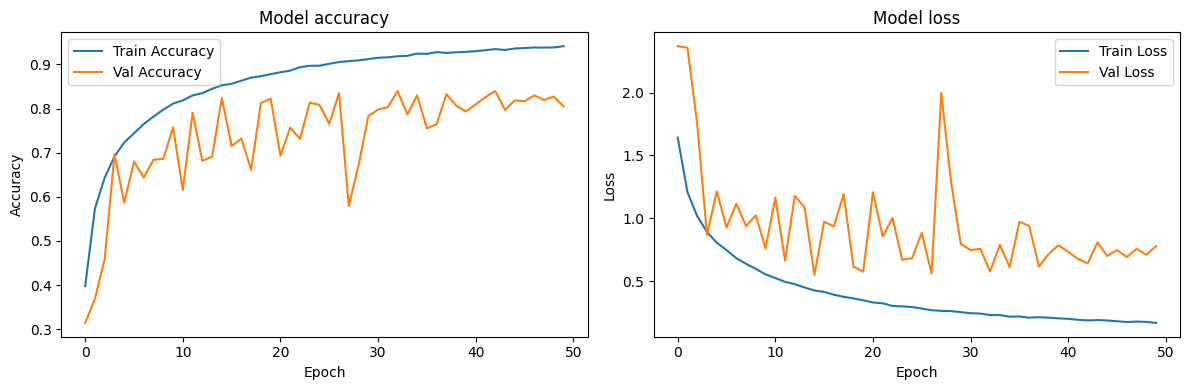

In [107]:
# Accessing the history data
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']
loss = r.history['loss']
val_loss = r.history['val_loss']

# Print out the history for verification
print("Accuracy: ", accuracy)
print("Validation Accuracy: ", val_accuracy)
print("Loss: ", loss)
print("Validation Loss: ", val_loss)

# Plotting the results
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Val Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [13]:
predic = model_cnn.predict(X_test)
predict_labels = np.argmax(predic, axis=1)

NameError: name 'r' is not defined

In [12]:
submission = np.column_stack((id_test, predict_labels))
np.savetxt('submission_cnn.csv', submission, delimiter=',', header='id, Label', comments='', fmt='%d')

In [ ]:
val_predictions = model_cnn.predict(X_val)
val_pred_labels = np.argmax(val_predictions, axis=1)
accuracy = accuracy_score(np.argmax(y_val, axis=1), val_pred_labels)
precision = precision_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
recall = recall_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
f1 = f1_score(np.argmax(y_val, axis=1), val_pred_labels, average='weighted')
cm = confusion_matrix(np.argmax(y_val, axis=1), val_pred_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [46]:
import tensorflow as tf
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Initialize the feature extractor and model
feature_extractor = ViTFeatureExtractor()
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=10)

# Preprocess function for images
def preprocess_images(images):
    # The feature extractor should handle resizing and normalization
    return feature_extractor(images=images, return_tensors="tf").pixel_values

# Convert numpy arrays to TensorFlow datasets
def create_tf_dataset(images, labels, batch_size=32):
    images = preprocess_images(images)
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
    return dataset

train_dataset = create_tf_dataset(X_new_train, y_new_train)
test_dataset = create_tf_dataset(X_val, y_val)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_dataset, epochs=10, validation_data=test_dataset)

/Users/vitaliigalkin/Desktop/MSA-Phase2/.venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
print(f"X_train shape: {X_new_train.shape}")
print(f"y_train shape: {y_new_train.shape}")
print(f"X_test shape: {X_val.shape}")

X_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 10)
X_test shape: (10000, 32, 32, 3)


# Summary

### YOLO and Azure Experience
I dont like the idea that the dataset I need to download and run it locally.Also, I cant select the GPU option but beccause of my subscription plan that I couldnt qoute for it. Also it already took like 2 hours to upload 5000 images to the Azure and I also had to upload 50000 images so at least 10 hoours and sometimes the internet can crash and I have to sit there and watch.  Also when train locally, it is heavy and I had to spend 1 day to get a trainin model for RESTnet and the result was not that good. The cost for me is too heavy for trying and training different deep learning models. Additionally, tunning hyperparameters in deep learning is computationally expensive for me in this stage as well. 

So I tried to use YOLO in Azure, and I already classify the traning data into the correct folders and prepared for that. But it took too long to unzip the folders in Azure. I plan to try other opensource dataset and check how the model work in Azure.

### Data Preprocessing
For data preprocessing, I made a function to resize and make the images more contasted by converting them to HSV space and then back using openCV, but it is too costly to precess all the images and my laptop crashed down several times so I had to give up this idea. But the function is still in my code. 

### Hyperparameter Tuning
As for Hyper parameter tuning, using early_stopping to tune the epoch for the model here. We can also add layers for MLP in trtaining the model but ut consumes more time. Also we can use the grid search for kenel size tuning asw well, but it is still too compucated expansive.

### Model Evaluation
I choosed 3 deep learning models: 

1. **MLP (Multi-Layer Perceptron):** 
 This model achieved the lowest accuracy on both the training and validation sets, likely due to insufficient layers. However, when I added more layers to the MLP, the training time significantly increased without a corresponding improvement in accuracy. This lack of improvement could be due to several factors, such as the model not being deep enough to capture the complexity of the data, or it could be suffering from issues like overfitting or inadequate hyperparameter tuning. Moreover, the MLP might not be the best architecture for the type of data I am working with, which could explain the poor performance.

2. **CNN (Convolutional Neural Network):**
 The CNN performed better than the MLP,I got a accuracy around 80%. but training it locally is still highly resource-intensive. Initial experiments showed promise, but optimizing the model requires significant computational power and time, which is challenging given my current hardware limitations. Despite these issues, the CNN is more suitable for the image data, and with proper tuning and adequate computational resources, it could potentially yield better results.

3. **ResNet:**
I also tried to use Restnet, appearantly it can achieve a better result when I was doing it on my training set. The training process repeatedly crashed my laptop due to its high resource demands, forcing me to abandon this model.

### Summary
I am still exploring the deep learning process extensively. Having studied neural network algorithms last semester, this is my first time applying them in practical coding scenarios and working with image data using Python, so there is a significant amount I still need to learn. At this stage, CNN has given me the best results. However, I believe there are several ways to improve the outcomes. Implementing preprocessing techniques such as resizing, enhancing image contrast, and flipping images to augment the dataset could make the model more robust and improve performance. Additionally, leveraging pretrained models like ResNet and fine-tuning their hyperparameters could lead to better results. Despite the progress, there is still much to learn and experiment with in deep learning to achieve optimal performance.












